In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path
from PIL import Image
from collections import Counter
import json
import cv2
import hashlib
from collections import defaultdict
import imagehash
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Set paths
data_dir = Path("../data/raw/PlantVillage")

# Get all image files
all_images = []
class_names = []

for class_dir in data_dir.iterdir():
    if class_dir.is_dir():
        class_name = class_dir.name
        images = list(class_dir.glob("*.jpg")) + list(class_dir.glob("*.JPG")) + list(class_dir.glob("*.png"))
        for img_path in images:
            all_images.append(img_path)
            class_names.append(class_name)

print(f"Total images found: {len(all_images)}")
print(f"Total classes: {len(set(class_names))}")

Total images found: 20637
Total classes: 15


In [3]:
# Setup and Hashing Functions
import hashlib
from collections import defaultdict
import imagehash

def calculate_md5(image_path):
    """Calculate MD5 hash of file"""
    hash_md5 = hashlib.md5()
    with open(image_path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

def calculate_perceptual_hash(image_path, hash_size=8):
    """Calculate perceptual hash using difference hash"""
    try:
        img = Image.open(image_path)
        return imagehash.dhash(img, hash_size=hash_size)
    except Exception as e:
        return None


Exact Duplicate Detection Results:
Total unique MD5 hashes: 20623
Exact duplicate groups found: 14
Total duplicate images: 14

Exact Duplicate Groups:

Group 1 (2 images):
  ../data/raw/PlantVillage/Tomato_healthy/e786ac89-29fe-47e3-b49e-b9a9ee7edd9d___GH_HL Leaf 342.1.JPG
  ../data/raw/PlantVillage/Tomato_healthy/37aad83b-7ff8-4b35-b3ed-fb8e0f54910b___GH_HL Leaf 342.1.JPG

Group 2 (2 images):
  ../data/raw/PlantVillage/Tomato_healthy/34c81c57-e1fa-49dd-a49d-34fe8b2385fe___GH_HL Leaf 466.1.JPG
  ../data/raw/PlantVillage/Tomato_healthy/068e324c-faf6-40d6-8f83-578907f1cac5___GH_HL Leaf 466.1.JPG

Group 3 (2 images):
  ../data/raw/PlantVillage/Tomato_healthy/505465db-407b-4e0a-8110-7479dad5261c___GH_HL Leaf 389.JPG
  ../data/raw/PlantVillage/Tomato_healthy/37203047-d8ba-43f7-b31e-d496c41c569c___GH_HL Leaf 389.JPG

Group 4 (2 images):
  ../data/raw/PlantVillage/Tomato_healthy/488feb1c-4b9f-44e7-8aa6-4103a9601f5f___GH_HL Leaf 434.JPG
  ../data/raw/PlantVillage/Tomato_healthy/a5de43e7-fc2f-

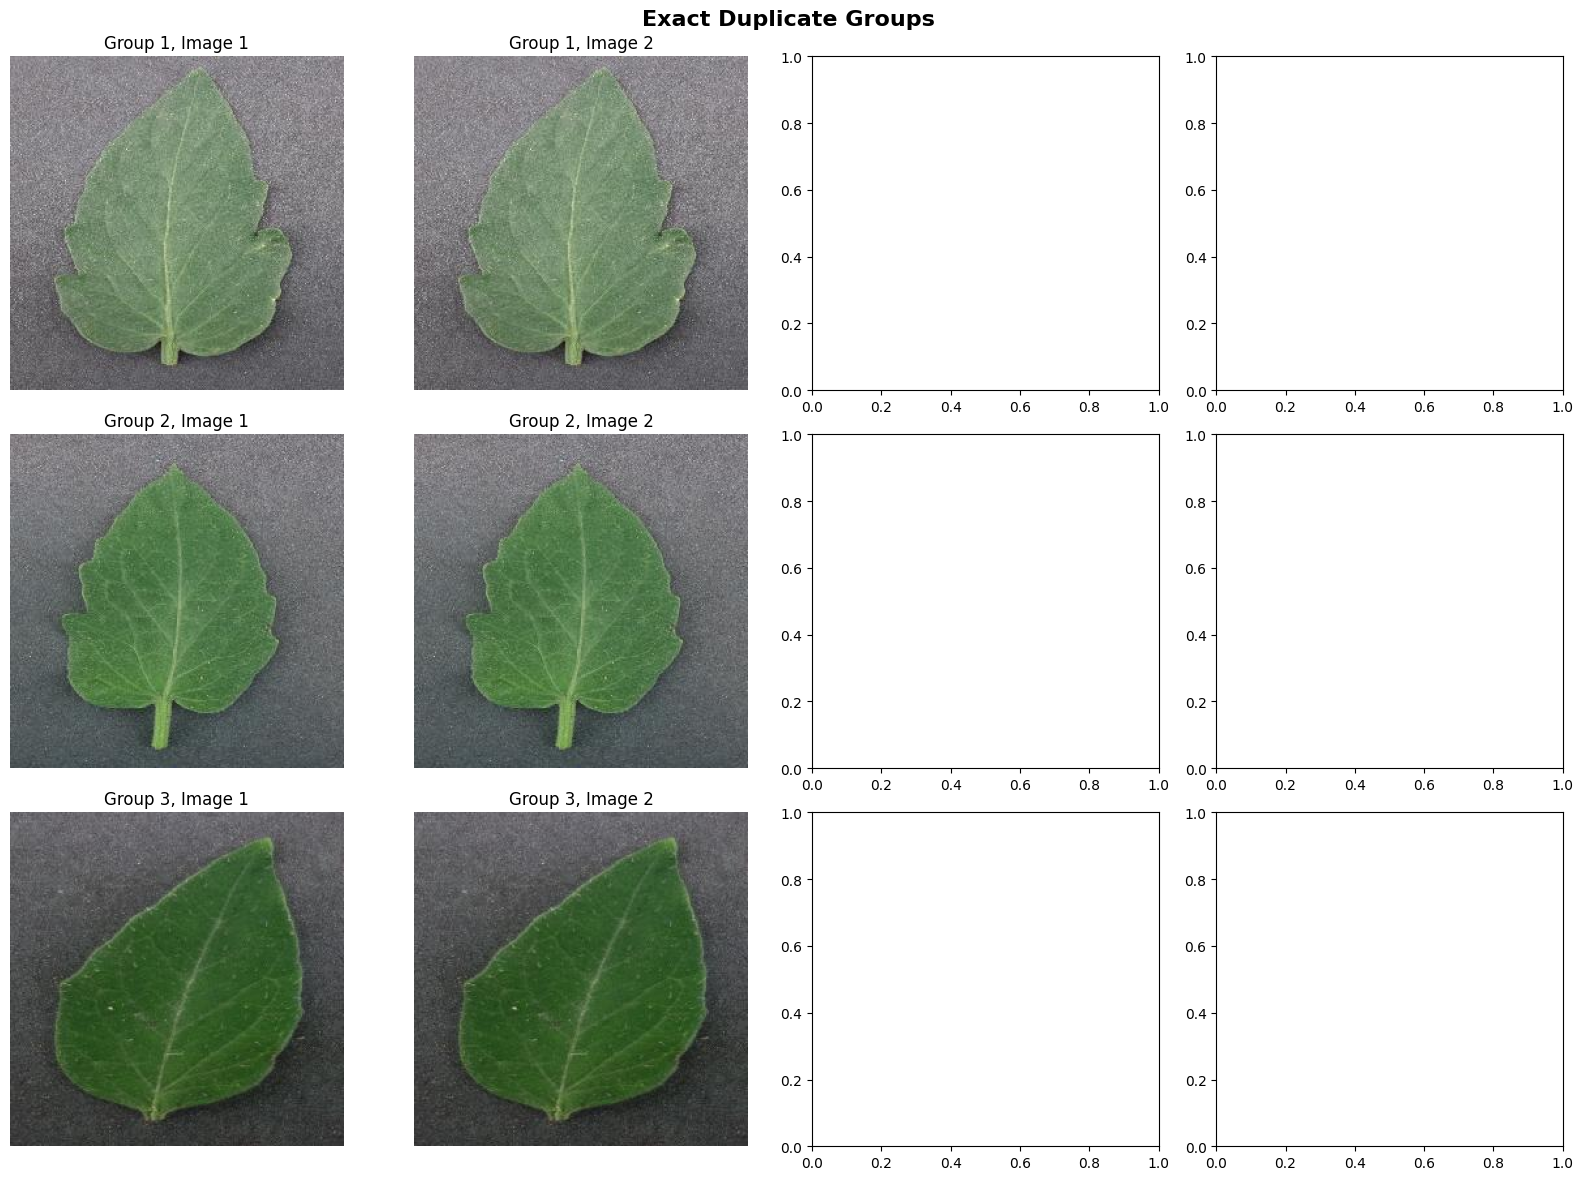

In [5]:
# Calculate MD5 hashes for all images
md5_hashes = {}
hash_to_images = defaultdict(list)

for img_path in all_images:
    md5_hash = calculate_md5(img_path)
    md5_hashes[img_path] = md5_hash
    hash_to_images[md5_hash].append(img_path)

# Find exact duplicates
exact_duplicates = {hash_val: paths for hash_val, paths in hash_to_images.items() if len(paths) > 1}

print(f"\nExact Duplicate Detection Results:")
print(f"Total unique MD5 hashes: {len(hash_to_images)}")
print(f"Exact duplicate groups found: {len(exact_duplicates)}")
print(f"Total duplicate images: {sum(len(paths) - 1 for paths in exact_duplicates.values())}")

# Show duplicate groups
if exact_duplicates:
    print("\nExact Duplicate Groups:")
    for idx, (hash_val, paths) in enumerate(list(exact_duplicates.items())[:5], 1):
        print(f"\nGroup {idx} ({len(paths)} images):")
        for path in paths:
            print(f"  {path}")
    
    # Visualize first few exact duplicate groups
    num_groups_to_show = min(3, len(exact_duplicates))
    if num_groups_to_show > 0:
        fig, axes = plt.subplots(num_groups_to_show, 4, figsize=(16, 4*num_groups_to_show))
        if num_groups_to_show == 1:
            axes = axes.reshape(1, -1)
        
        for group_idx, (hash_val, paths) in enumerate(list(exact_duplicates.items())[:num_groups_to_show]):
            for img_idx in range(min(4, len(paths))):
                if img_idx < len(paths):
                    img = Image.open(paths[img_idx])
                    axes[group_idx, img_idx].imshow(img)
                    axes[group_idx, img_idx].set_title(f'Group {group_idx+1}, Image {img_idx+1}')
                    axes[group_idx, img_idx].axis('off')
                else:
                    axes[group_idx, img_idx].axis('off')
        
        plt.suptitle('Exact Duplicate Groups', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
else:
    print("\nNo exact duplicates found")

### Exact Duplicate Detection: Key Findings
- Dataset has 20,623 unique images by MD5 hash.
- Found 14 duplicate groups, each with 2 identical files.
- Total affected duplicate files are very small relative to dataset size (minor issue overall).
- Duplicates shown are concentrated in *Tomato_healthy*, so this class is slightly over-represented by repeated samples.

### Implication
- If duplicates leak across train/val/test splits, evaluation can look artificially better (data leakage).
- Even a small number of duplicates should be removed to keep splits clean and reproducible.

### Recommended Action
- Keep one file per duplicate group and remove the rest.
-  Perform deduplication before train/val/test split.
-  Save a duplicate log (hash, kept file, removed file) for auditability.
-  Recompute class counts after cleanup to confirm final distribution.

Detecting near-duplicates using perceptual hashing...
Calculated perceptual hashes for 20637 images
Comparing 20637 image pairs
Progress: 0/20637
Progress: 1000/20637
Progress: 2000/20637
Progress: 3000/20637
Progress: 4000/20637
Progress: 5000/20637
Progress: 6000/20637
Progress: 7000/20637
Progress: 8000/20637
Progress: 9000/20637
Progress: 10000/20637
Progress: 11000/20637
Progress: 12000/20637
Progress: 13000/20637
Progress: 14000/20637
Progress: 15000/20637
Progress: 16000/20637
Progress: 17000/20637
Progress: 18000/20637
Progress: 19000/20637
Progress: 20000/20637

Near-Duplicate Detection Results:
Hamming distance threshold: 5
Near-duplicate pairs found: 102
Cross-class near-duplicates (potential leakage): 9


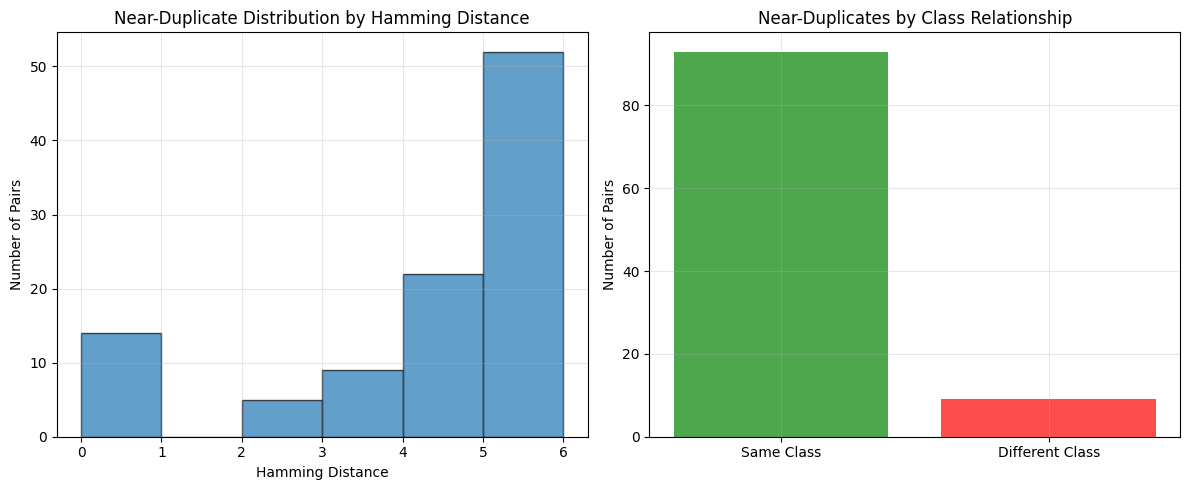

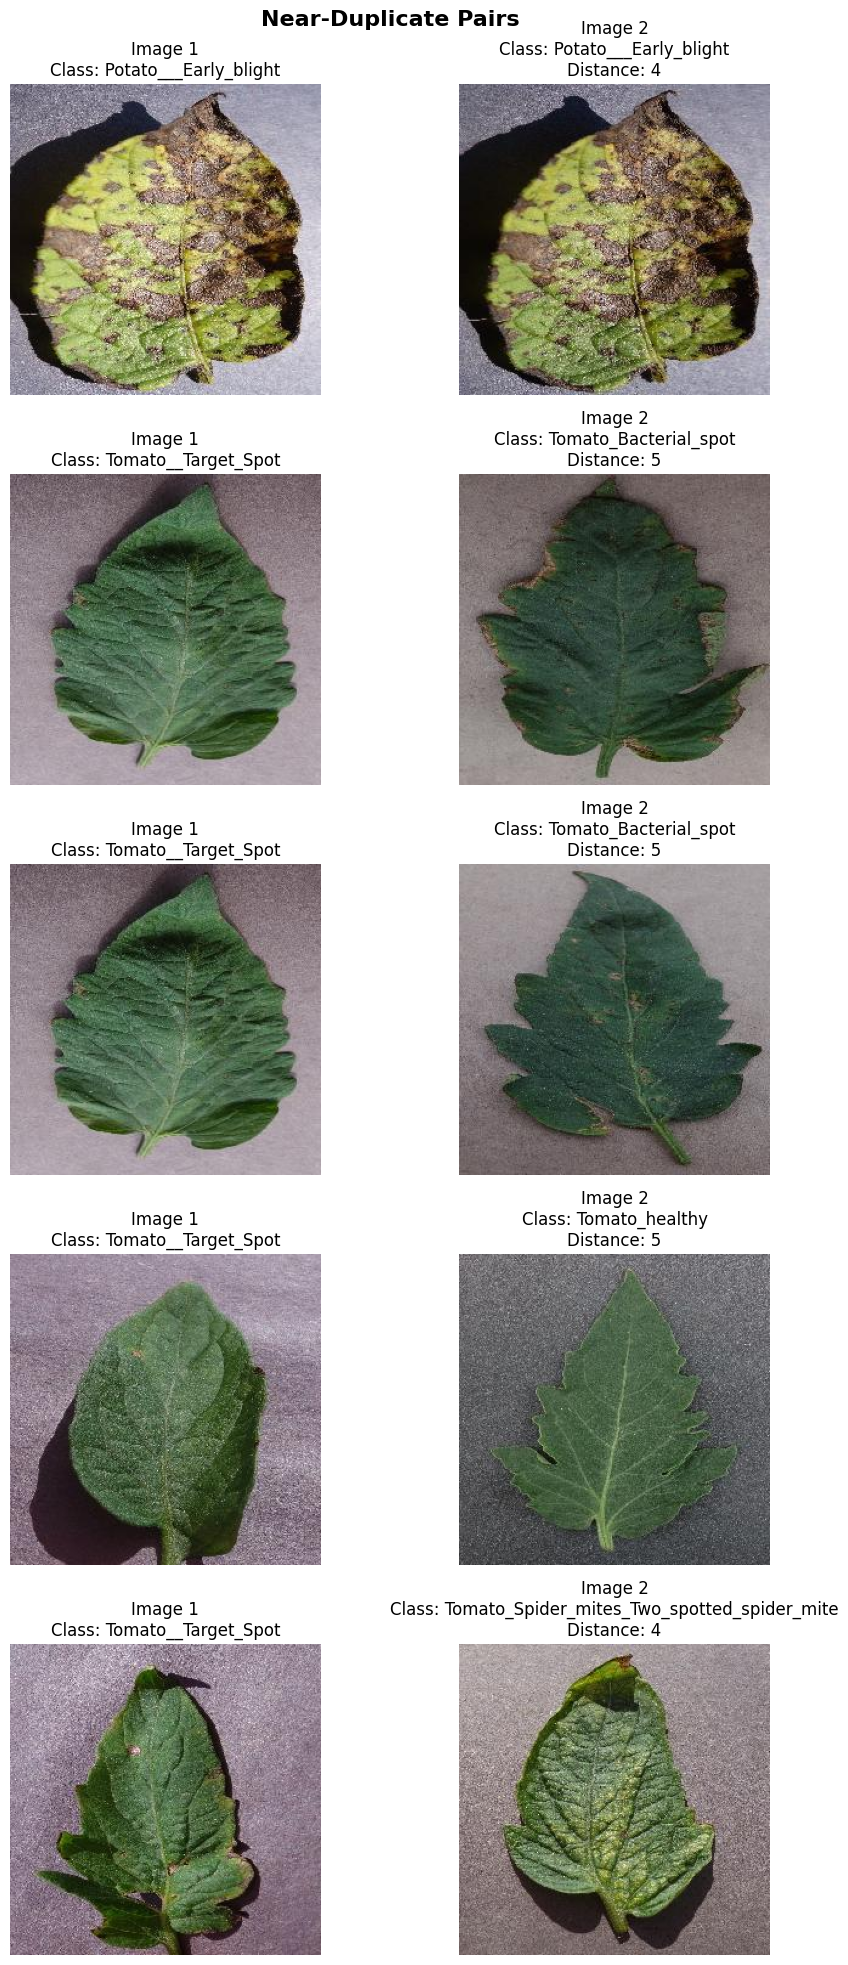

In [6]:
# Near-Duplicate Detection
print("Detecting near-duplicates using perceptual hashing...")

# Calculate perceptual hashes
perceptual_hashes = {}
for img_path in all_images:
    phash = calculate_perceptual_hash(img_path)
    if phash is not None:
        perceptual_hashes[img_path] = phash

print(f"Calculated perceptual hashes for {len(perceptual_hashes)} images")

# Find near-duplicates (Hamming distance threshold)
near_duplicates = []
hamming_threshold = 5 

image_paths = list(perceptual_hashes.keys())
print(f"Comparing {len(image_paths)} image pairs")

for i in range(len(image_paths)):
    if i % 1000 == 0:
        print(f"Progress: {i}/{len(image_paths)}")
    
    for j in range(i + 1, len(image_paths)):
        img1, img2 = image_paths[i], image_paths[j]
        hash1, hash2 = perceptual_hashes[img1], perceptual_hashes[img2]
        
        hamming_dist = hash1 - hash2
        
        if hamming_dist <= hamming_threshold:
            near_duplicates.append({
                'image1': img1,
                'image2': img2,
                'hamming_distance': hamming_dist,
                'class1': img1.parent.name,
                'class2': img2.parent.name
            })

print(f"\nNear-Duplicate Detection Results:")
print(f"Hamming distance threshold: {hamming_threshold}")
print(f"Near-duplicate pairs found: {len(near_duplicates)}")

# Check for cross-class duplicates (potential data leakage)
cross_class_duplicates = [dup for dup in near_duplicates if dup['class1'] != dup['class2']]
print(f"Cross-class near-duplicates (potential leakage): {len(cross_class_duplicates)}")

# Show near-duplicate distribution by Hamming distance
if near_duplicates:
    hamming_distances = [dup['hamming_distance'] for dup in near_duplicates]
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(hamming_distances, bins=range(0, hamming_threshold + 2), edgecolor='black', alpha=0.7)
    plt.xlabel('Hamming Distance')
    plt.ylabel('Number of Pairs')
    plt.title('Near-Duplicate Distribution by Hamming Distance')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    same_class = len([d for d in near_duplicates if d['class1'] == d['class2']])
    diff_class = len(cross_class_duplicates)
    plt.bar(['Same Class', 'Different Class'], [same_class, diff_class], color=['green', 'red'], alpha=0.7)
    plt.ylabel('Number of Pairs')
    plt.title('Near-Duplicates by Class Relationship')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Visualize some near-duplicate pairs
    num_pairs_to_show = min(5, len(near_duplicates))
    if num_pairs_to_show > 0:
        fig, axes = plt.subplots(num_pairs_to_show, 2, figsize=(10, 4*num_pairs_to_show))
        if num_pairs_to_show == 1:
            axes = axes.reshape(1, -1)
        
        for idx in range(num_pairs_to_show):
            dup = near_duplicates[idx]
            
            img1 = Image.open(dup['image1'])
            axes[idx, 0].imshow(img1)
            axes[idx, 0].set_title(f"Image 1\nClass: {dup['class1']}")
            axes[idx, 0].axis('off')
            
            img2 = Image.open(dup['image2'])
            axes[idx, 1].imshow(img2)
            axes[idx, 1].set_title(f"Image 2\nClass: {dup['class2']}\nDistance: {dup['hamming_distance']}")
            axes[idx, 1].axis('off')
        
        plt.suptitle('Near-Duplicate Pairs', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
else:
    print("\nNo near-duplicates found")

### Near-Duplicate Detection Key Findings
- Perceptual hashing over 20,637 images found 102 near-duplicate pairs (Hamming <= 5).
- 9 pairs are cross-class, which is the most important risk because it can indicate label noise or split leakage.
- Most pairs are likely within-class variants (minor angle/light/background changes), which are less risky.

### Implication

- Cross-class near-duplicates can confuse the model and inflate/deflate metrics depending on where they appear.
- Near-duplicates across train/val/test can create data leakage even when labels are correct.
- Threshold 5 is fairly strict; these are likely genuinely similar images worth review.

### Recommended Action

- Manually review all 9 cross-class pairs first and fix label or remove one image per conflicting pair.
- Group near-duplicates and enforce group-aware splitting (same group must stay in one split only).
- Keep within-class near-duplicates unless they are extreme repeats; they can still help robustness.
- After cleanup, rerun near-duplicate check and regenerate split statistics.

In [7]:
# Cell 4: Analysis and Save Results
print("Analyzing duplicate detection results and saving...")

# Create summary statistics
duplicate_summary = {
    'total_images': len(all_images),
    'unique_images': len(hash_to_images),
    'exact_duplicate_groups': len(exact_duplicates),
    'exact_duplicate_images': sum(len(paths) - 1 for paths in exact_duplicates.values()),
    'near_duplicate_pairs': len(near_duplicates),
    'cross_class_near_duplicates': len(cross_class_duplicates),
    'hamming_threshold': hamming_threshold
}

print("\nDuplicate Detection Summary:")
for key, value in duplicate_summary.items():
    print(f"{key}: {value}")

# Save exact duplicates
if exact_duplicates:
    exact_dup_data = []
    for hash_val, paths in exact_duplicates.items():
        for i, path in enumerate(paths):
            exact_dup_data.append({
                'group_id': hash_val[:8],
                'image_path': str(path),
                'class_name': path.parent.name,
                'group_size': len(paths),
                'image_index': i + 1
            })
    
    df_exact_duplicates = pd.DataFrame(exact_dup_data)
    exact_output_path = Path("../data/processed/exact_duplicates.csv")
    exact_output_path.parent.mkdir(parents=True, exist_ok=True)
    df_exact_duplicates.to_csv(exact_output_path, index=False)
    print(f"\nExact duplicates saved to: {exact_output_path}")

# Save near-duplicates
if near_duplicates:
    df_near_duplicates = pd.DataFrame(near_duplicates)
    df_near_duplicates['image1'] = df_near_duplicates['image1'].astype(str)
    df_near_duplicates['image2'] = df_near_duplicates['image2'].astype(str)
    
    near_output_path = Path("../data/processed/near_duplicates.csv")
    df_near_duplicates.to_csv(near_output_path, index=False)
    print(f"Near-duplicates saved to: {near_output_path}")
    
    # Save cross-class duplicates separately for manual review
    if cross_class_duplicates:
        df_cross_class = pd.DataFrame(cross_class_duplicates)
        df_cross_class['image1'] = df_cross_class['image1'].astype(str)
        df_cross_class['image2'] = df_cross_class['image2'].astype(str)
        
        cross_output_path = Path("../data/processed/cross_class_duplicates.csv")
        df_cross_class.to_csv(cross_output_path, index=False)
        print(f"Cross-class duplicates saved to: {cross_output_path}")
        print(f"\nWARNING: {len(cross_class_duplicates)} cross-class duplicates detected!")
        print("Review these carefully to prevent data leakage during train/test split")

# Save summary
summary_df = pd.DataFrame([duplicate_summary])
summary_output_path = Path("../data/processed/duplicate_detection_summary.csv")
summary_df.to_csv(summary_output_path, index=False)
print(f"\nSummary saved to: {summary_output_path}")

print("\nDuplicate detection complete!")

Analyzing duplicate detection results and saving...

Duplicate Detection Summary:
total_images: 20637
unique_images: 20623
exact_duplicate_groups: 14
exact_duplicate_images: 14
near_duplicate_pairs: 102
cross_class_near_duplicates: 9
hamming_threshold: 5

Exact duplicates saved to: ../data/processed/exact_duplicates.csv
Near-duplicates saved to: ../data/processed/near_duplicates.csv
Cross-class duplicates saved to: ../data/processed/cross_class_duplicates.csv

Review these carefully to prevent data leakage during train/test split

Summary saved to: ../data/processed/duplicate_detection_summary.csv

Duplicate detection complete!


In [8]:
# Update Metadata with Duplicate Detection Results
print("Updating metadata with duplicate detection results...")

metadata_path = Path("../../data/metadata/dataset_metadata.json")
metadata_path.parent.mkdir(parents=True, exist_ok=True)

if metadata_path.exists():
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
else:
    metadata = {}

# Add duplicate detection results to metadata
metadata['duplicate_detection'] = {
    'analysis_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'total_images': len(all_images),
    'unique_images': len(hash_to_images),
    'exact_duplicates': {
        'groups_found': len(exact_duplicates),
        'total_duplicate_images': sum(len(paths) - 1 for paths in exact_duplicates.values()),
        'percentage': float(sum(len(paths) - 1 for paths in exact_duplicates.values()) / len(all_images) * 100)
    },
    'near_duplicates': {
        'hamming_threshold': hamming_threshold,
        'pairs_found': len(near_duplicates),
        'cross_class_duplicates': len(cross_class_duplicates),
        'same_class_duplicates': len(near_duplicates) - len(cross_class_duplicates)
    },
    'data_leakage_risk': {
        'cross_class_near_duplicates': len(cross_class_duplicates),
        'risk_level': 'HIGH' if cross_class_duplicates else 'LOW'
    },
    'files_generated': {
        'exact_duplicates_csv': str(exact_output_path) if exact_duplicates else None,
        'near_duplicates_csv': str(near_output_path) if near_duplicates else None,
        'cross_class_duplicates_csv': str(cross_output_path) if cross_class_duplicates else None,
        'summary_csv': str(summary_output_path)
    }
}

# Save updated metadata
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=4)

print(f"Duplicate detection metadata saved to: {metadata_path}")
print("All metadata updated successfully!")

Updating metadata with duplicate detection results...
Duplicate detection metadata saved to: ../../data/metadata/dataset_metadata.json
All metadata updated successfully!
